In [10]:
student_id =  "98101771"
student_name = "Morteza Seyedi"

print("your student id:", student_id)
print("your name:", student_name)

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from tqdm import trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

your student id: 98101771
your name: Morteza Seyedi


model :

In [11]:
class Forward_Forward_1(nn.Module):
    def __init__(self):
        super(Forward_Forward_1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        return x
    
class Forward_Forward_2(nn.Module):
    def __init__(self):
        super(Forward_Forward_2, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(300, 100),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.fc1(x)
        return x

Supervised :

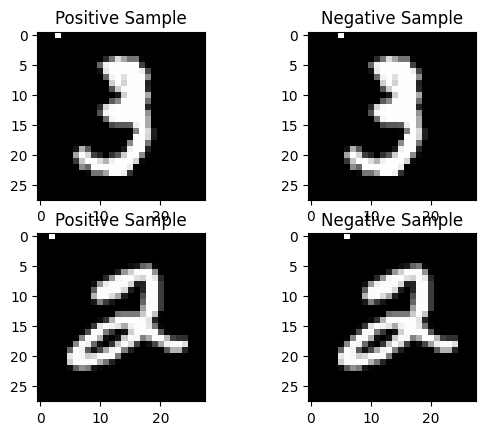

In [12]:
# preprocessing
pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

neg_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

pos_train_data.data = pos_train_data.data.float() / 255
neg_train_data.data = neg_train_data.data.float() / 255

pos_train_data.data[:, 0, :10] = torch.nn.functional.one_hot(pos_train_data.targets)
neg_y_one_hot = torch.nn.functional.one_hot(neg_train_data.targets)
for i in range(len(neg_y_one_hot)):
    random_index = torch.randint(0, 10, (1,))
    one_position = torch.argmax(neg_y_one_hot[i])
    while random_index == one_position:
        random_index = torch.randint(0, 10, (1,))
    neg_y_one_hot[i][random_index] = 1
    neg_y_one_hot[i][one_position] = 0

neg_train_data.data[:, 0, :10] = neg_y_one_hot

# show 2 samples from positive and negative datasets
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(pos_train_data.data[10], cmap='gray')
axs[0, 0].set_title('Positive Sample')
axs[0, 1].imshow(neg_train_data.data[10], cmap='gray')
axs[0, 1].set_title('Negative Sample')
axs[1, 0].imshow(pos_train_data.data[5], cmap='gray')
axs[1, 0].set_title('Positive Sample')
axs[1, 1].imshow(neg_train_data.data[5], cmap='gray')
axs[1, 1].set_title('Negative Sample')
plt.show()


In [13]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)
ff_layer2 = Forward_Forward_2().to(device)

threshold = 2
batch_size = 1000
epochs = 20
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(ff_layer2.parameters(), lr=0.01)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=False)
neg_train_loader = DataLoader(neg_train_data, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    for i, (pos_data, neg_data) in enumerate(zip(pos_train_loader, neg_train_loader)):
        pos_data = pos_data[0].to(device)
        neg_data = neg_data[0].to(device)
        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_neg = ff_layer1(neg_data)
        loss1 = torch.mean(torch.log(1 + torch.exp(torch.cat((threshold - layer1_output_pos, layer1_output_neg - threshold)))))
        loss1.backward()
        optimizer1.step()

        # second layer
        optimizer2.zero_grad()
        layer2_output_pos = ff_layer2(layer1_output_pos.detach())
        layer2_output_neg = ff_layer2(layer1_output_neg.detach())
        loss2 = torch.mean(torch.log(1 + torch.exp(torch.cat((threshold - layer2_output_pos, layer2_output_neg - threshold)))))
        loss2.backward()
        optimizer2.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}, loss2: {loss2.item()}')

epoch: 0, loss1: 0.7394701838493347, loss2: 1.1150676012039185
epoch: 1, loss1: 0.7055432796478271, loss2: 1.1141411066055298
epoch: 2, loss1: 0.6956164240837097, loss2: 1.1139585971832275
epoch: 3, loss1: 0.6933164596557617, loss2: 1.1139144897460938
epoch: 4, loss1: 0.6927874088287354, loss2: 1.1139047145843506
epoch: 5, loss1: 0.6926428079605103, loss2: 1.1139068603515625
epoch: 6, loss1: 0.692592203617096, loss2: 1.113922119140625
epoch: 7, loss1: 0.6925682425498962, loss2: 1.11403489112854
epoch: 8, loss1: 0.6925541758537292, loss2: 1.1139284372329712
epoch: 9, loss1: 0.6925448179244995, loss2: 1.1139103174209595
epoch: 10, loss1: 0.6925382018089294, loss2: 1.1139588356018066
epoch: 11, loss1: 0.6925334334373474, loss2: 1.1139298677444458
epoch: 12, loss1: 0.6925297975540161, loss2: 1.1139062643051147
epoch: 13, loss1: 0.6925271153450012, loss2: 1.1140029430389404
epoch: 14, loss1: 0.6925250291824341, loss2: 1.1139771938323975
epoch: 15, loss1: 0.6925232410430908, loss2: 1.1139425

In [6]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
for param in ff_layer2.parameters():
    param.requires_grad = False

class Forward_Forward(nn.Module):
    def __init__(self):
        super(Forward_Forward, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = ff_layer2
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        return x

model2 = Forward_Forward().to(device)

# test the model on the test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
test_data.data = test_data.data.float() / 255

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data_0 = data.clone()
        data_0.data[:, :, 0,0] = 1
        data_0 = data_0.to(device)
        data_1 = data.clone()
        data_1.data[:, :, 0,1] = 1
        data_1 = data_1.to(device)
        data_2 = data.clone()
        data_2.data[:, :, 0,2] = 1
        data_2 = data_2.to(device)
        data_3 = data.clone()
        data_3.data[:, :, 0,3] = 1
        data_3 = data_3.to(device)
        data_4 = data.clone()
        data_4.data[:, :, 0,4] = 1
        data_4 = data_4.to(device)
        data_5 = data.clone()
        data_5.data[:, :, 0,5] = 1
        data_5 = data_5.to(device)
        data_6 = data.clone()
        data_6.data[:, :, 0,6] = 1
        data_6 = data_6.to(device)
        data_7 = data.clone()
        data_7.data[:, :, 0,7] = 1
        data_7 = data_7.to(device)
        data_8 = data.clone()
        data_8.data[:, :, 0,8] = 1
        data_8 = data_8.to(device)
        data_9 = data.clone()
        data_9.data[:, :, 0,9] = 1
        data_9 = data_9.to(device)

        goodness_0 = torch.mean(model2(data_0), dim=1)
        goodness_1 = torch.mean(model2(data_1), dim=1)
        goodness_2 = torch.mean(model2(data_2), dim=1)
        goodness_3 = torch.mean(model2(data_3), dim=1)
        goodness_4 = torch.mean(model2(data_4), dim=1)
        goodness_5 = torch.mean(model2(data_5), dim=1)
        goodness_6 = torch.mean(model2(data_6), dim=1)
        goodness_7 = torch.mean(model2(data_7), dim=1)
        goodness_8 = torch.mean(model2(data_8), dim=1)
        goodness_9 = torch.mean(model2(data_9), dim=1)
        
        goodness = torch.stack((goodness_0, goodness_1, goodness_2, goodness_3, goodness_4, goodness_5, goodness_6, goodness_7, goodness_8, goodness_9), dim=1)

        target = target.to(device)
        predicted = torch.argmax(goodness, dim=1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'accuracy: {correct / total}')


accuracy: 0.0958


unsupervised :

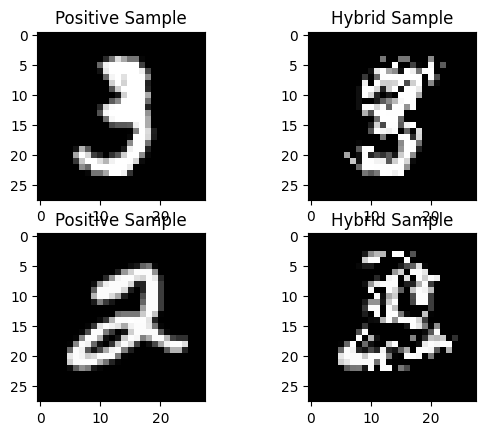

In [7]:
# preprocessing
pos_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

hybrid_train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

pos_train_data.data = pos_train_data.data.float() / 255
hybrid_train_data.data = hybrid_train_data.data.float() / 255

# create a random 0 and 1 mask for hybrid data
mask = torch.randint(0, 2, (len(hybrid_train_data), 1, 28, 28))
mask_invert = torch.ones_like(mask) - mask
# shuffle the hybrid data
random_index = torch.randperm(len(hybrid_train_data))

for i in range(len(hybrid_train_data)):
    hybrid_train_data.data[i] = pos_train_data.data[i] * mask[i] + hybrid_train_data.data[random_index[i]] * mask_invert[i]

# show 2 samples from positive and hybrid datasets
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(pos_train_data.data[10], cmap='gray')
axs[0, 0].set_title('Positive Sample')
axs[0, 1].imshow(hybrid_train_data.data[10], cmap='gray')
axs[0, 1].set_title('Hybrid Sample')
axs[1, 0].imshow(pos_train_data.data[5], cmap='gray')
axs[1, 0].set_title('Positive Sample')
axs[1, 1].imshow(hybrid_train_data.data[5], cmap='gray')
axs[1, 1].set_title('Hybrid Sample')
plt.show()


In [8]:
# training one layer of forward forward
ff_layer1 = Forward_Forward_1().to(device)
ff_layer2 = Forward_Forward_2().to(device)

threshold = 15
batch_size = 1000
epochs = 40
optimizer1 = torch.optim.Adam(ff_layer1.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(ff_layer2.parameters(), lr=0.01)
pos_train_loader = DataLoader(pos_train_data, batch_size=batch_size, shuffle=True)
hybrid_train_loader = DataLoader(hybrid_train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for i, (pos_data, hybrid_data) in enumerate(zip(pos_train_loader, hybrid_train_loader)):
        pos_data = pos_data[0].to(device)
        hybrid_data = hybrid_data[0].to(device)
        # first layer
        optimizer1.zero_grad()
        layer1_output_pos = ff_layer1(pos_data)
        layer1_output_hybrid = ff_layer1(hybrid_data)
        loss1 = torch.mean(torch.log(1 + torch.exp(torch.cat((threshold - layer1_output_pos, layer1_output_hybrid - threshold)))))
        loss1.backward()
        optimizer1.step()

        # second layer
        optimizer2.zero_grad()
        layer2_output_pos = ff_layer2(layer1_output_pos.detach())
        layer2_output_hybrid = ff_layer2(layer1_output_hybrid.detach())
        loss2 = torch.mean(torch.log(1 + torch.exp(torch.cat((threshold - layer2_output_pos, layer2_output_hybrid - threshold)))))
        loss2.backward()
        optimizer2.step()
    
    print(f'epoch: {epoch}, loss1: {loss1.item()}, loss2: {loss2.item()}')

epoch: 0, loss1: 3.282588243484497, loss2: 3.3324146270751953
epoch: 1, loss1: 2.957258462905884, loss2: 2.8920180797576904
epoch: 2, loss1: 2.732875108718872, loss2: 2.6573565006256104
epoch: 3, loss1: 2.55684494972229, loss2: 2.4809346199035645
epoch: 4, loss1: 2.461585760116577, loss2: 2.317981719970703
epoch: 5, loss1: 2.3058552742004395, loss2: 2.2380175590515137
epoch: 6, loss1: 2.1616098880767822, loss2: 2.0670034885406494
epoch: 7, loss1: 2.164313316345215, loss2: 2.2905771732330322
epoch: 8, loss1: 2.0333094596862793, loss2: 2.387399673461914
epoch: 9, loss1: 2.0390465259552, loss2: 2.4254627227783203
epoch: 10, loss1: 1.9131044149398804, loss2: 2.4352803230285645
epoch: 11, loss1: 1.854395866394043, loss2: 2.2979583740234375
epoch: 12, loss1: 1.7114298343658447, loss2: 2.891417980194092
epoch: 13, loss1: 1.673295021057129, loss2: 3.451681137084961
epoch: 14, loss1: 1.5394314527511597, loss2: 3.3912243843078613
epoch: 15, loss1: 1.461230754852295, loss2: 3.4054811000823975
epo

In [9]:
# making a full classifier with the forward forward

for param in ff_layer1.parameters():
    param.requires_grad = False
for param in ff_layer2.parameters():
    param.requires_grad = False

class Forward_Forward_complete(nn.Module):
    def __init__(self):
        super(Forward_Forward_complete, self).__init__()
        self.forward_forward_1 = ff_layer1
        self.forward_forward_2 = ff_layer2
        self.fc1 = nn.Sequential(
            nn.Linear(100, 10),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.forward_forward_1(x)
        x = self.forward_forward_2(x)
        x = self.fc1(x)
        return x

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
train_data.data = train_data.data.float() / 255
model2 = Forward_Forward_complete().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
epochs = 60
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model2(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'epoch: {epoch}, loss: {loss.item()}')

# test the model on the test data
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)
test_data.data = test_data.data.float() / 255

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model2(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'accuracy: {correct / total}')


epoch: 0, loss: 2.3571321964263916
epoch: 1, loss: 2.306537628173828
epoch: 2, loss: 2.3094146251678467
epoch: 3, loss: 2.309725761413574
epoch: 4, loss: 2.302255868911743
epoch: 5, loss: 2.3104143142700195
epoch: 6, loss: 2.309636116027832
epoch: 7, loss: 2.309694528579712
epoch: 8, loss: 2.3040456771850586
epoch: 9, loss: 2.305586099624634
epoch: 10, loss: 2.304170608520508
epoch: 11, loss: 2.311357259750366
epoch: 12, loss: 2.3115649223327637
epoch: 13, loss: 2.312321662902832
epoch: 14, loss: 2.308192491531372
epoch: 15, loss: 2.3059122562408447
epoch: 16, loss: 2.3092129230499268
epoch: 17, loss: 2.313617706298828
epoch: 18, loss: 2.302213668823242
epoch: 19, loss: 2.301041841506958
epoch: 20, loss: 2.3093152046203613
epoch: 21, loss: 2.3019800186157227
epoch: 22, loss: 2.3043642044067383
epoch: 23, loss: 2.3067221641540527
epoch: 24, loss: 2.308748483657837
epoch: 25, loss: 2.31315541267395
epoch: 26, loss: 2.308584451675415
epoch: 27, loss: 2.310434341430664
epoch: 28, loss: 2.3